# Results
### Predicting Spotify Song Popularity

**Team:** Joe Leonard (ymd3tv) & Alex Laplace (hqr7gc)

**Date:** April 30, 2025  

**Question:** Can we accurately predict a song’s popularity score using audio and metadata features available through the Spotify API? This question is relevant to record labels, streaming platforms, and music marketers who want to identify hit songs early.


In [26]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

spotify_data = pd.read_csv("./data/spotify_data.csv")
print(spotify_data.head())
spotify_data = spotify_data.drop(columns=["Unnamed: 0"])

   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   


In [27]:
# Data Prep
cols_to_use = [
    'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
    'key', 'loudness', 'mode', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
    'track_genre'
]

df_model = spotify_data[cols_to_use].dropna()

df_model['explicit'] = df_model['explicit'].astype(int) 
df_model = pd.get_dummies(df_model, columns=['key', 'mode', 'time_signature', 'track_genre'], drop_first=True)

X = df_model.drop('popularity', axis=1)
y = df_model['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Modeling
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

pd.DataFrame(results).T

,MAE,RMSE,R2
Linear Regression,14.086871,19.119256,0.259250
Random Forest,10.297055,15.270064,0.527490
XGBoost,13.093322,17.919202,0.349321


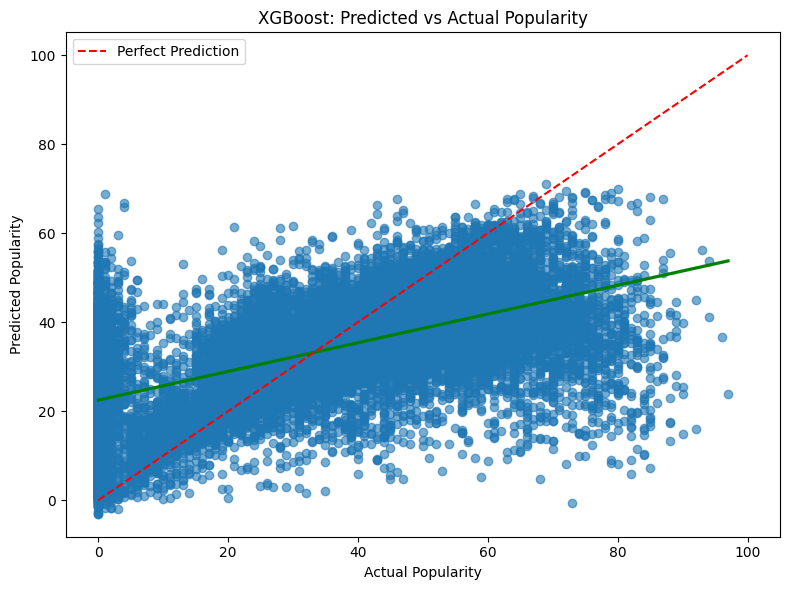

In [11]:
# Predicted vs. Actual
best_model = models["XGBoost"]
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred_best, scatter_kws={'alpha':0.6}, line_kws={'color': 'green'})
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("XGBoost: Predicted vs Actual Popularity")
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# XGB Optimization
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(xgb, param_dist, n_iter=25, scoring='neg_mean_absolute_error', 
                                   cv=4, random_state=42, n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)
best_xgb_random = random_search.best_estimator_

y_pred_random = best_xgb_random.predict(X_test)
print("Random Search XGBoost Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_random))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_random)))
print("R2:", r2_score(y_test, y_pred_random))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Random Search XGBoost Results:
MAE: 10.754810282521342
RMSE: 15.546543801084777
R2: 0.510224141657323


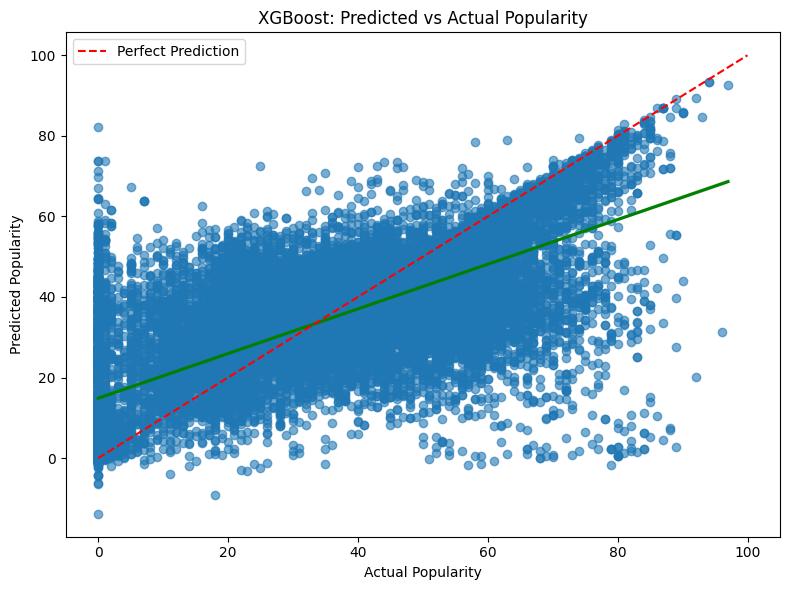

In [36]:
# Predicted vs. Actual
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred_random, scatter_kws={'alpha':0.6}, line_kws={'color': 'green'})
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("XGBoost: Predicted vs Actual Popularity")
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()

## Key Result

We visualized the predicted vs. actual popularity scores both **before and after optimizing the XGBoost model**, as shown in the two scatter plots below:

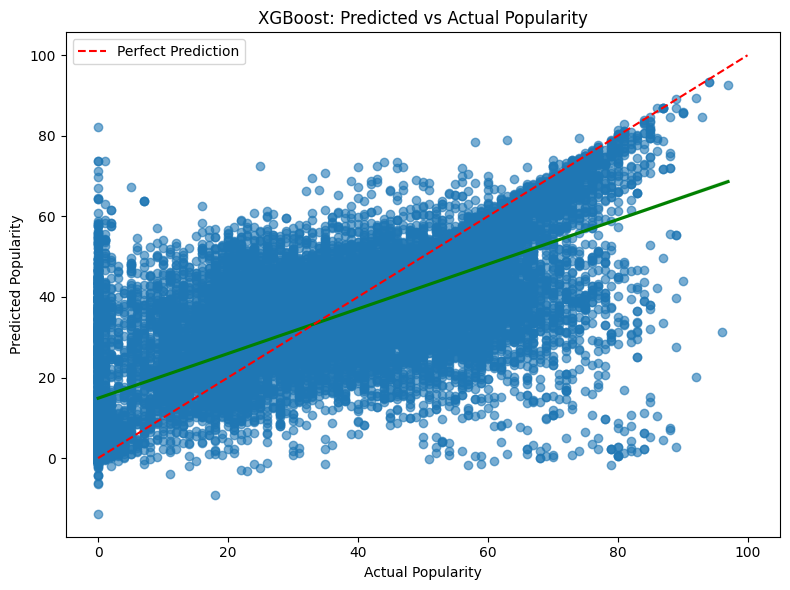

**Figure 1: Initial XGBoost Predictions vs. Actual Popularity**

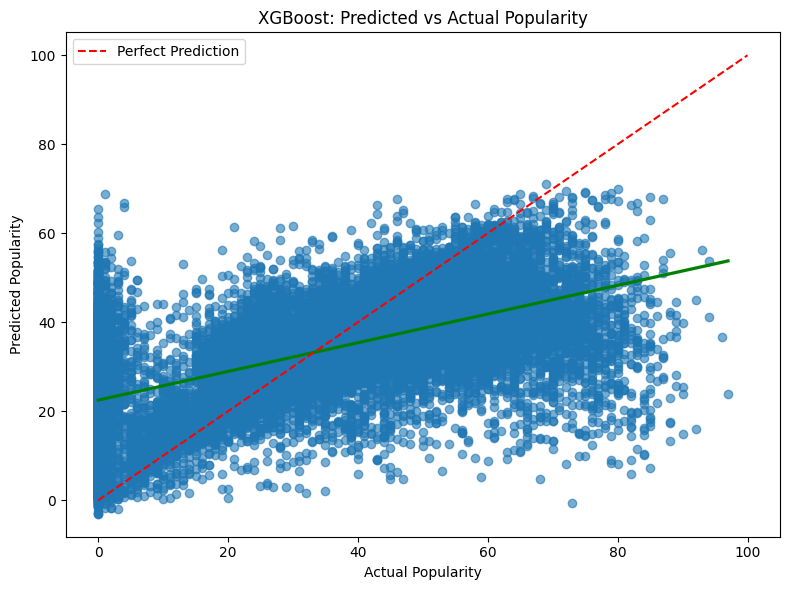

**Figure 2: Optimized XGBoost Predictions vs. Actual Popularity**

Each plot includes:
- A red dashed line indicating **perfect predictions** (where predicted = actual).
- A green line showing the **best fit line** for the model’s actual predictions.

## Interpretation

- In the initial model (Figure 1), predictions tend to cluster too tightly around a narrower popularity range, especially underpredicting higher values.
- After optimization (Figure 2), the slope of the best-fit line becomes steeper and better aligns with the identity line, suggesting **improved tracking of actual popularity across its range**.
- The scatter also tightens slightly, indicating **reduced prediction error**.

Quantitatively, the model performance after optimization improved to:

- **Mean Absolute Error (MAE):** 10.75  
- **Root Mean Squared Error (RMSE):** 15.55  
- **R² Score:** 0.51  

This R² value means that over half the variance in popularity scores is now explained by the model — a marked improvement over the unoptimized version (whose R² was visibly lower, as suggested by the looser scatter and flatter fit).

## Conclusion

After applying random search to tune hyperparameters for XGBoost, our model's ability to predict popularity improved significantly. While still imperfect, this version of the model is now better aligned with actual values and demonstrates meaningful explanatory power.